# 3.2-Clustering and further filtering

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-04-14"

## Introduction

Clustering and filtering doublets

## Libraries

In [2]:
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(harmony)
}))

## Parameters

In [3]:
#dr_here(show_reason = TRUE)
source(here("SCGRES_99_100/sc_analysis/misc/paths.R"))
source(here("utils/bin.R"))

set.seed(0)

## Load data

In [4]:
seurat_obj <- readRDS(here(glue("{clust}/{robj_dir}/dimred_combined_object_T0_CD45neg.rds")))

### First clustering to localize doublets

In [5]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "pca", dims = 1:20)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0,
  max_resolution = 0.6,
  step = 0.02
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18258
Number of edges: 582893

Running Louvain algorithm...
Maximum modularity in 10 random starts: 1.0000
Number of communities: 1
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18258
Number of edges: 582893

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9827
Number of communities: 3
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18258
Number of edges: 582893

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9660
Number of communities: 4
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18258
Number of edges: 582893

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9526
Number of communities: 5
Elapsed time: 2 seconds
Modularity Optim

In [6]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

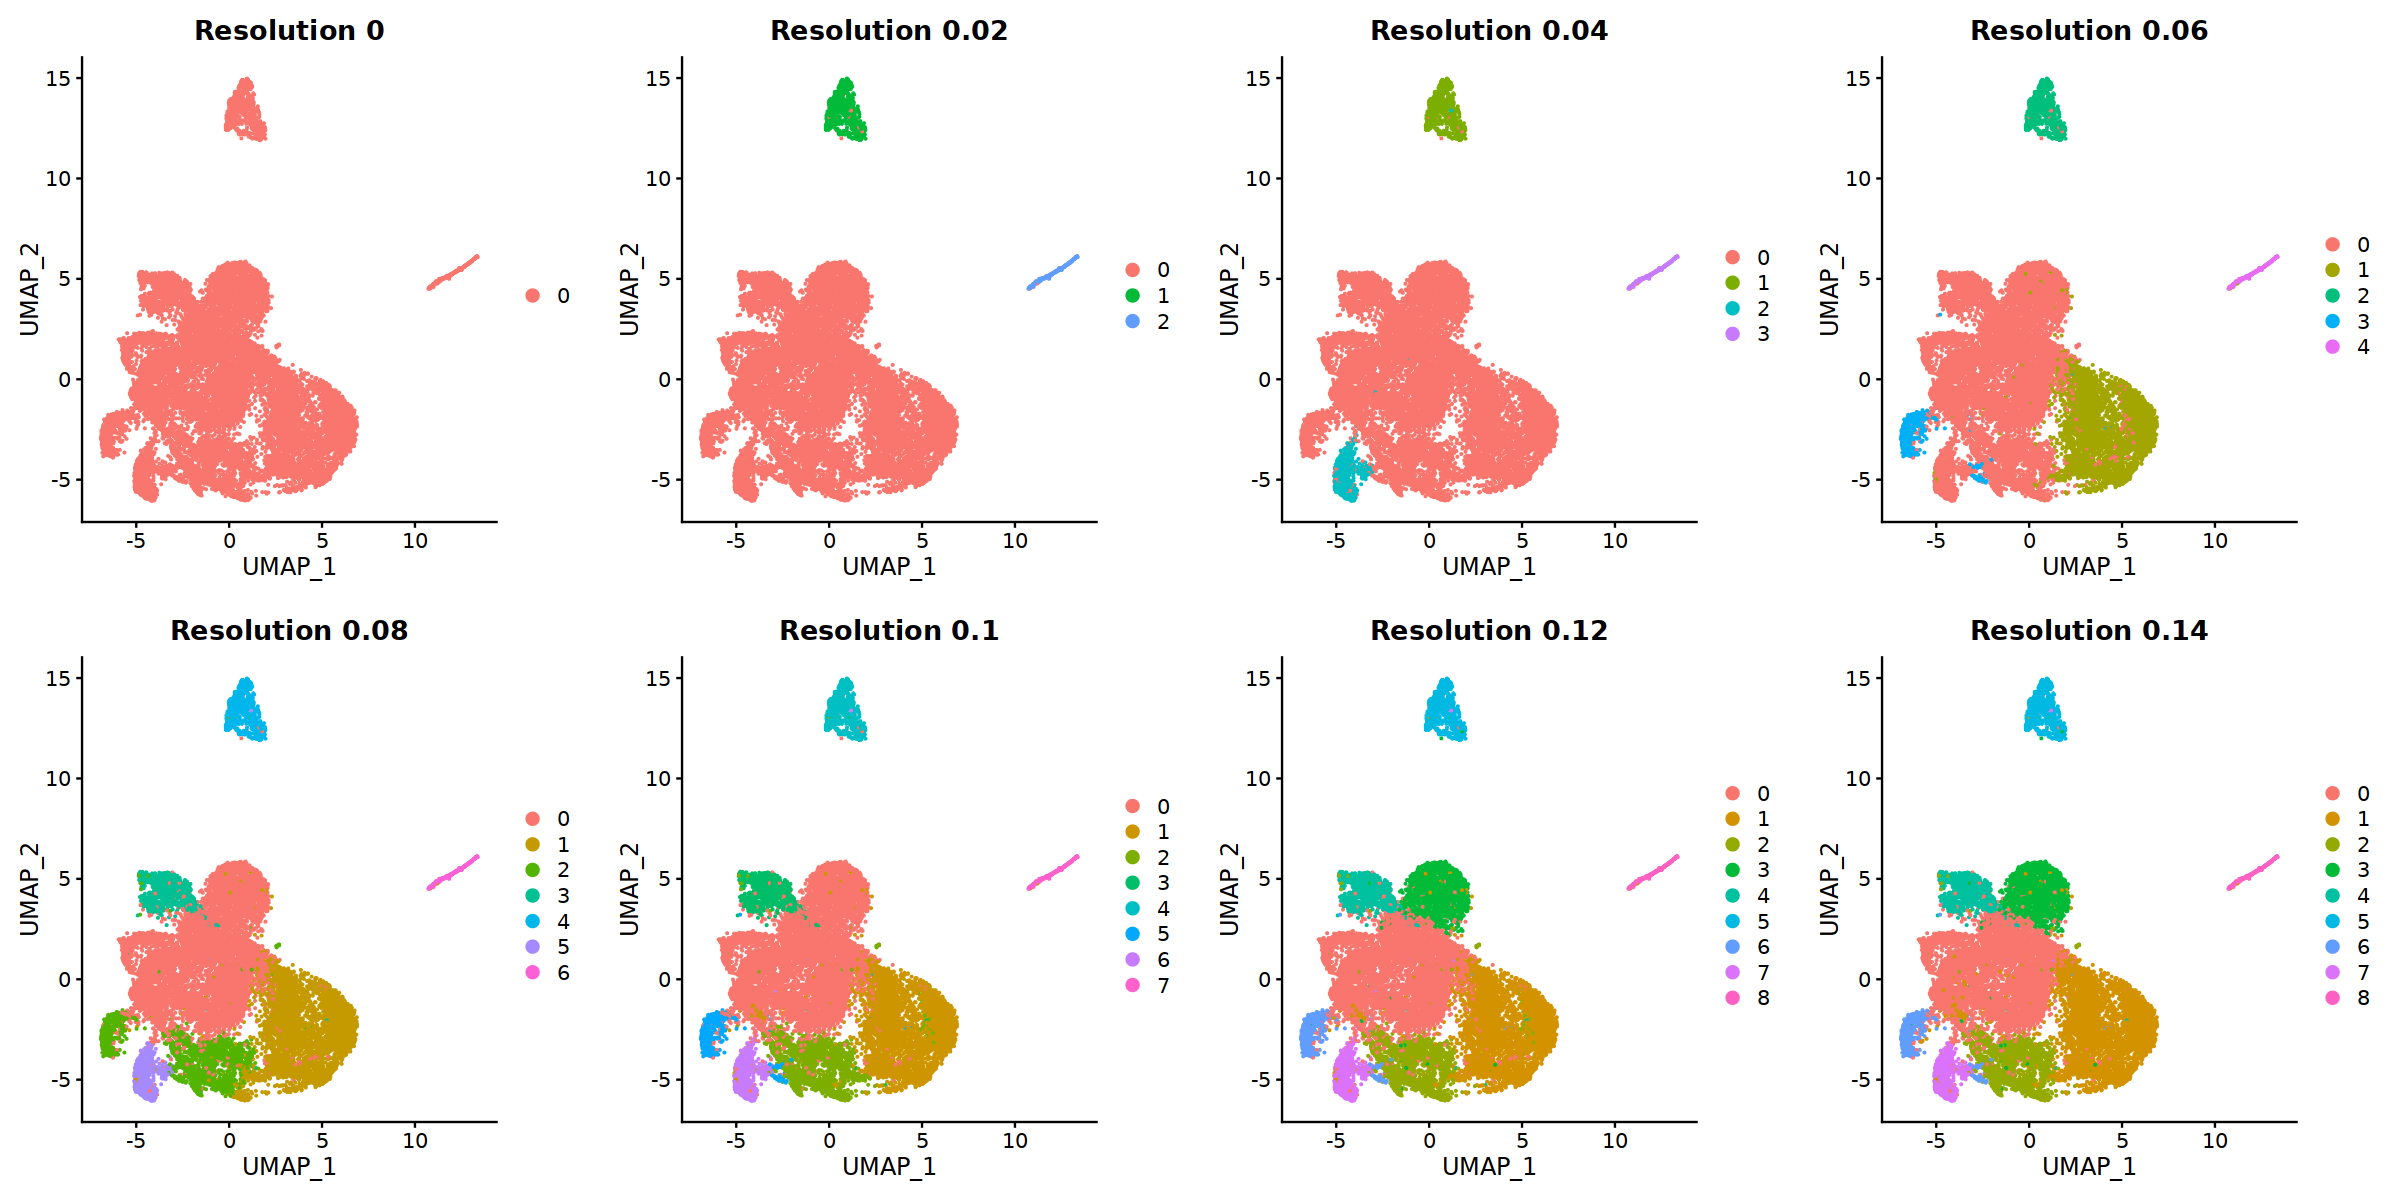

In [7]:
options(repr.plot.width = 20, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=2)
cp

In [8]:
reso = 0.15

In [9]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18258
Number of edges: 582893

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9309
Number of communities: 9
Elapsed time: 3 seconds


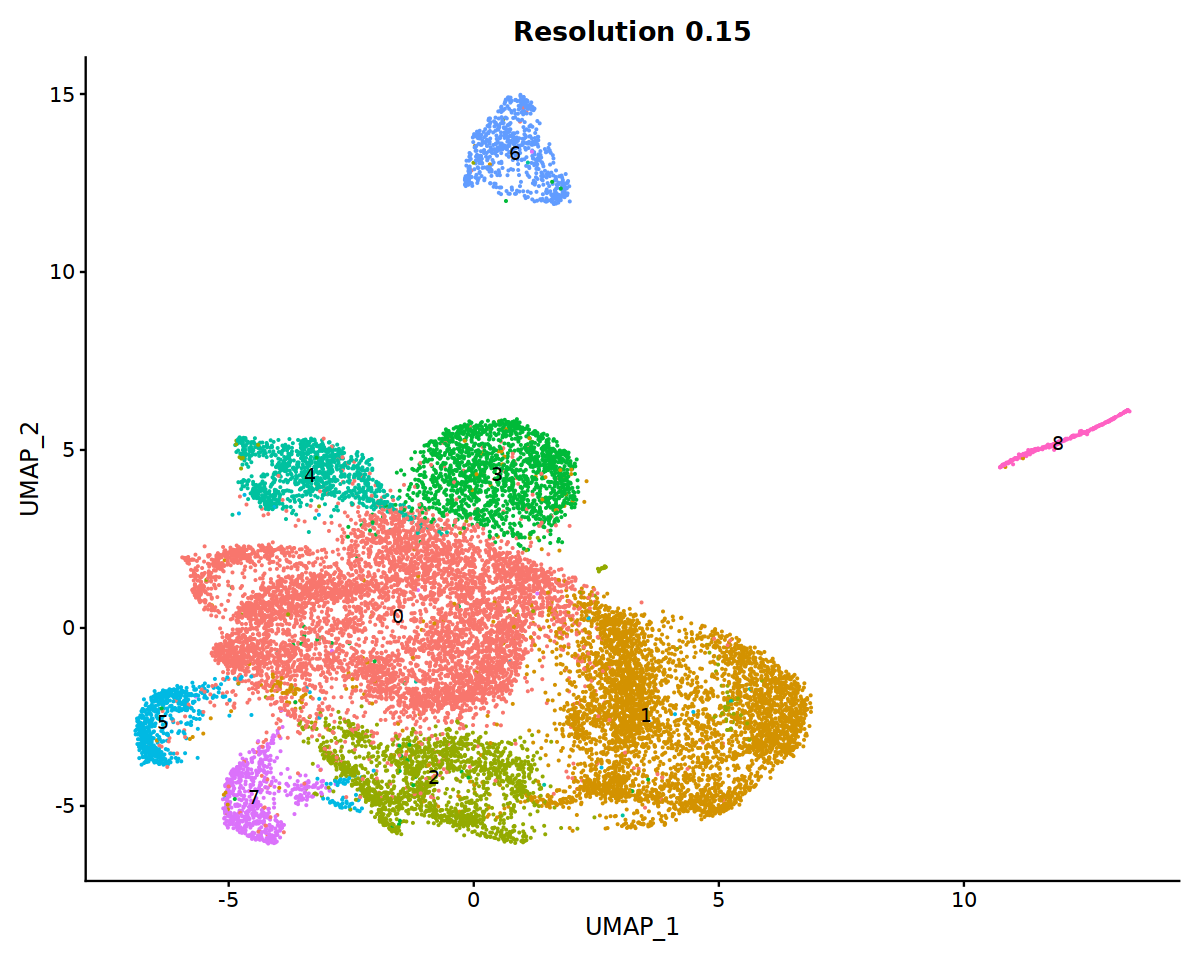

In [10]:
options(repr.plot.width = 10, repr.plot.height = 8, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

In [11]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, 
                              logfc.threshold = 0.1, only.pos = T,
                              random.seed=0, max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [12]:
rna.markers <- rna.markers %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC))

In [13]:
c <- 0
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster gene    
IL1RAPL1 4.310595e-36 1.5121297  0.367 0.118 1.329043e-31 0       IL1RAPL1
TNC      1.234706e-24 1.1283918  0.233 0.057 3.806847e-20 0       TNC     
OPCML    4.090481e-21 1.0453704  0.249 0.080 1.261177e-16 0       OPCML   
DLGAP1   7.204624e-18 0.8442985  0.520 0.352 2.221330e-13 0       DLGAP1  
SEMA3D   8.259878e-20 0.7829837  0.416 0.211 2.546686e-15 0       SEMA3D  
NELL2    5.380724e-20 0.7648572  0.571 0.396 1.658985e-15 0       NELL2

In [14]:
c <- 1
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster
CDH18       6.665252e-83 1.674402   0.525 0.134  2.055030e-78 1      
SLIT2      6.441179e-135 1.651731   0.615 0.093 1.985944e-130 1      
MSR1       2.590211e-114 1.428664   0.934 0.495 7.986139e-110 1      
CCSER1      7.215041e-97 1.319460   0.913 0.486  2.224542e-92 1      
PCDH11X     1.490975e-48 1.161173   0.444 0.133  4.596973e-44 1      
AC093866.1  4.291102e-47 1.021187   0.336 0.065  1.323033e-42 1      
           gene      
CDH18      CDH18     
SLIT2      SLIT2     
MSR1       MSR1      
CCSER1     CCSER1    
PCDH11X    PCDH11X   
AC093866.1 AC093866.1

In [15]:
c <- 2
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
HIST1H1B  5.078380e-86 2.291798   0.745 0.371  1.565766e-81 2       HIST1H1B
HIST1H4C 2.826353e-101 2.268955   0.855 0.558  8.714211e-97 2       HIST1H4C
TOP2A    8.028013e-227 2.124191   0.942 0.227 2.475197e-222 2       TOP2A   
CENPF    7.742731e-213 2.005832   0.928 0.251 2.387239e-208 2       CENPF   
HMGB2    1.390307e-216 1.976378   0.943 0.377 4.286596e-212 2       HMGB2   
MKI67    2.119316e-208 1.968797   0.916 0.232 6.534274e-204 2       MKI67

In [16]:
c <- 3
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene 
PTPRD 4.318080e-118 1.882871   0.687 0.181 1.331350e-113 3       PTPRD
SGCZ   1.084940e-55 1.770849   0.438 0.111  3.345086e-51 3       SGCZ 
CNTN4  4.081352e-62 1.413121   0.381 0.081  1.258362e-57 3       CNTN4
DGKB1  2.122814e-80 1.412086   0.808 0.451  6.545062e-76 3       DGKB 
RMST   4.723864e-65 1.212581   0.368 0.068  1.456462e-60 3       RMST 
NEGR1  2.141910e-27 1.190340   0.296 0.094  6.603936e-23 3       NEGR1

In [17]:
c <- 4
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster
AL357507.11 9.556066e-167 2.256294   0.707 0.092 2.946326e-162 4      
TRPS1       3.432075e-189 1.996102   0.697 0.062 1.058178e-184 4      
BCAN         1.549270e-28 1.976724   0.164 0.022  4.776708e-24 4      
SEMA6D1     1.734332e-154 1.912572   0.827 0.221 5.347292e-150 4      
KAZN        6.300047e-104 1.845996   0.500 0.069  1.942431e-99 4      
MATN21       7.878099e-96 1.784414   0.672 0.247  2.428975e-91 4      
            gene      
AL357507.11 AL357507.1
TRPS1       TRPS1     
BCAN        BCAN      
SEMA6D1     SEMA6D    
KAZN        KAZN      
MATN21      MATN2

In [18]:
c <- 5
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster
TENM21      7.754277e-162 2.200979   0.877 0.208 2.390799e-157 5      
AL357507.12  4.566487e-86 1.941960   0.577 0.110  1.407939e-81 5      
CSMD1        4.632226e-97 1.880968   0.557 0.109  1.428208e-92 5      
PI15         9.779753e-84 1.807492   0.613 0.148  3.015293e-79 5      
RALYL1       1.093575e-84 1.692019   0.476 0.059  3.371712e-80 5      
COL12A12     2.845537e-80 1.527206   0.688 0.204  8.773359e-76 5      
            gene      
TENM21      TENM2     
AL357507.12 AL357507.1
CSMD1       CSMD1     
PI15        PI15      
RALYL1      RALYL     
COL12A12    COL12A1

In [19]:
c <- 6
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene  
COL4A1 5.501442e-298 5.258720   0.992 0.086 1.696205e-293 6       COL4A1
ACTA2  3.376750e-164 5.059980   0.675 0.070 1.041120e-159 6       ACTA2 
TAGLN  5.990220e-162 4.241709   0.651 0.046 1.846905e-157 6       TAGLN 
COL4A2 2.214551e-291 4.164698   0.950 0.040 6.827905e-287 6       COL4A2
BGN    4.585532e-244 4.046531   0.834 0.033 1.413811e-239 6       BGN   
CALD1  6.904334e-242 3.725524   0.980 0.512 2.128744e-237 6       CALD1

In [20]:
c <- 7
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
FBN2      1.090690e-251 3.034787   0.882 0.036 3.362816e-247 7       FBN2    
AGMO      7.877512e-159 2.198984   0.781 0.132 2.428795e-154 7       AGMO    
ADAMTSL12  8.882860e-83 2.119861   0.575 0.125  2.738764e-78 7       ADAMTSL1
ADGRB32   1.179852e-116 1.754840   0.822 0.245 3.637721e-112 7       ADGRB3  
DYNC1I11  6.505698e-108 1.616489   0.694 0.155 2.005837e-103 7       DYNC1I1 
FN11       8.328151e-38 1.584413   0.548 0.282  2.567735e-33 7       FN1

In [21]:
c <- 8
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene   
ESM1     1.902557e-240 5.558689   0.924 0.015 5.865963e-236 8       ESM1   
PECAM1   1.066200e-215 5.116494   0.997 0.109 3.287309e-211 8       PECAM1 
PLVAP    1.295470e-253 5.062497   0.969 0.014 3.994192e-249 8       PLVAP  
SPARCL11 8.004621e-219 5.058702   0.972 0.087 2.467985e-214 8       SPARCL1
VWF      2.358392e-264 4.803738   0.969 0.006 7.271396e-260 8       VWF    
ANGPT21  2.141296e-221 4.748266   0.959 0.061 6.602043e-217 8       ANGPT2

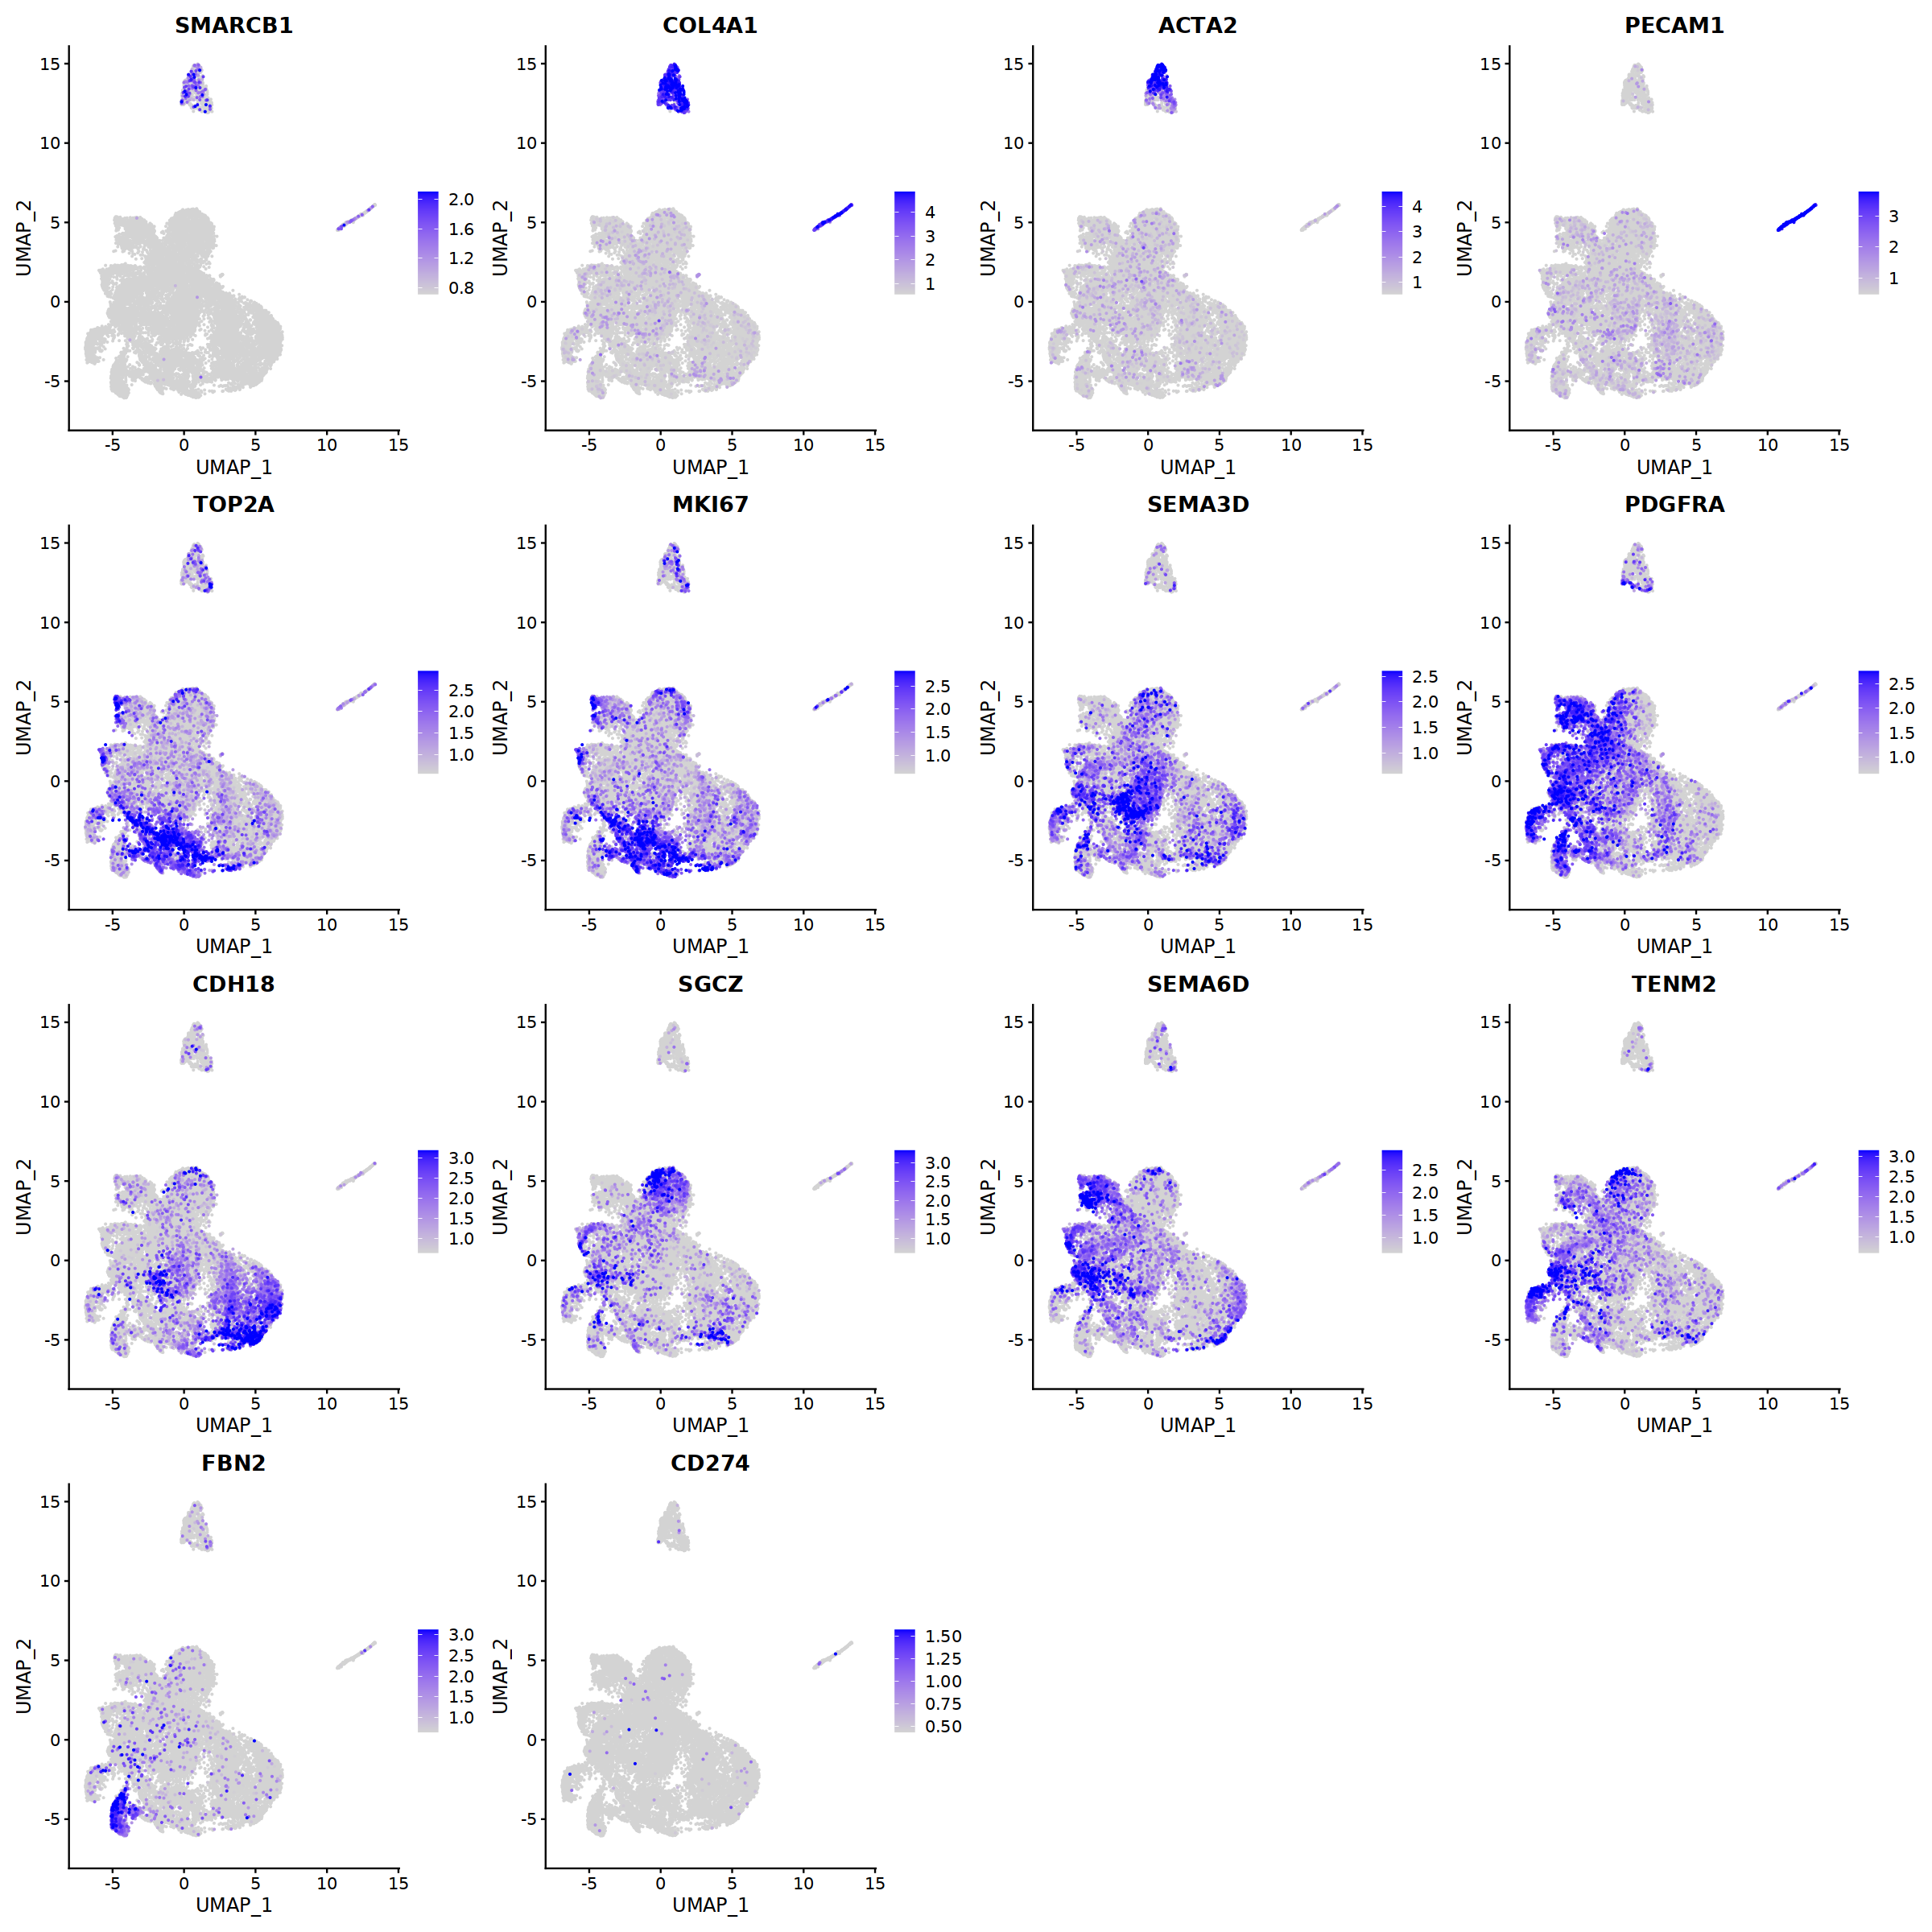

In [22]:
options(repr.plot.width = 20, repr.plot.height = 20, warn=-1,verbose = FALSE)

var = c("SMARCB1","COL4A1","ACTA2", "PECAM1",
        "TOP2A", "MKI67", "SEMA3D", "PDGFRA","CDH18", "SGCZ","SEMA6D",
        "TENM2", "FBN2", "CD274")
# show plots
FeaturePlot(seurat_obj, reduction = "umap", feature=var, 
            order = T, ncol=4, min.cutoff = "q05", max.cutoff = "q95")

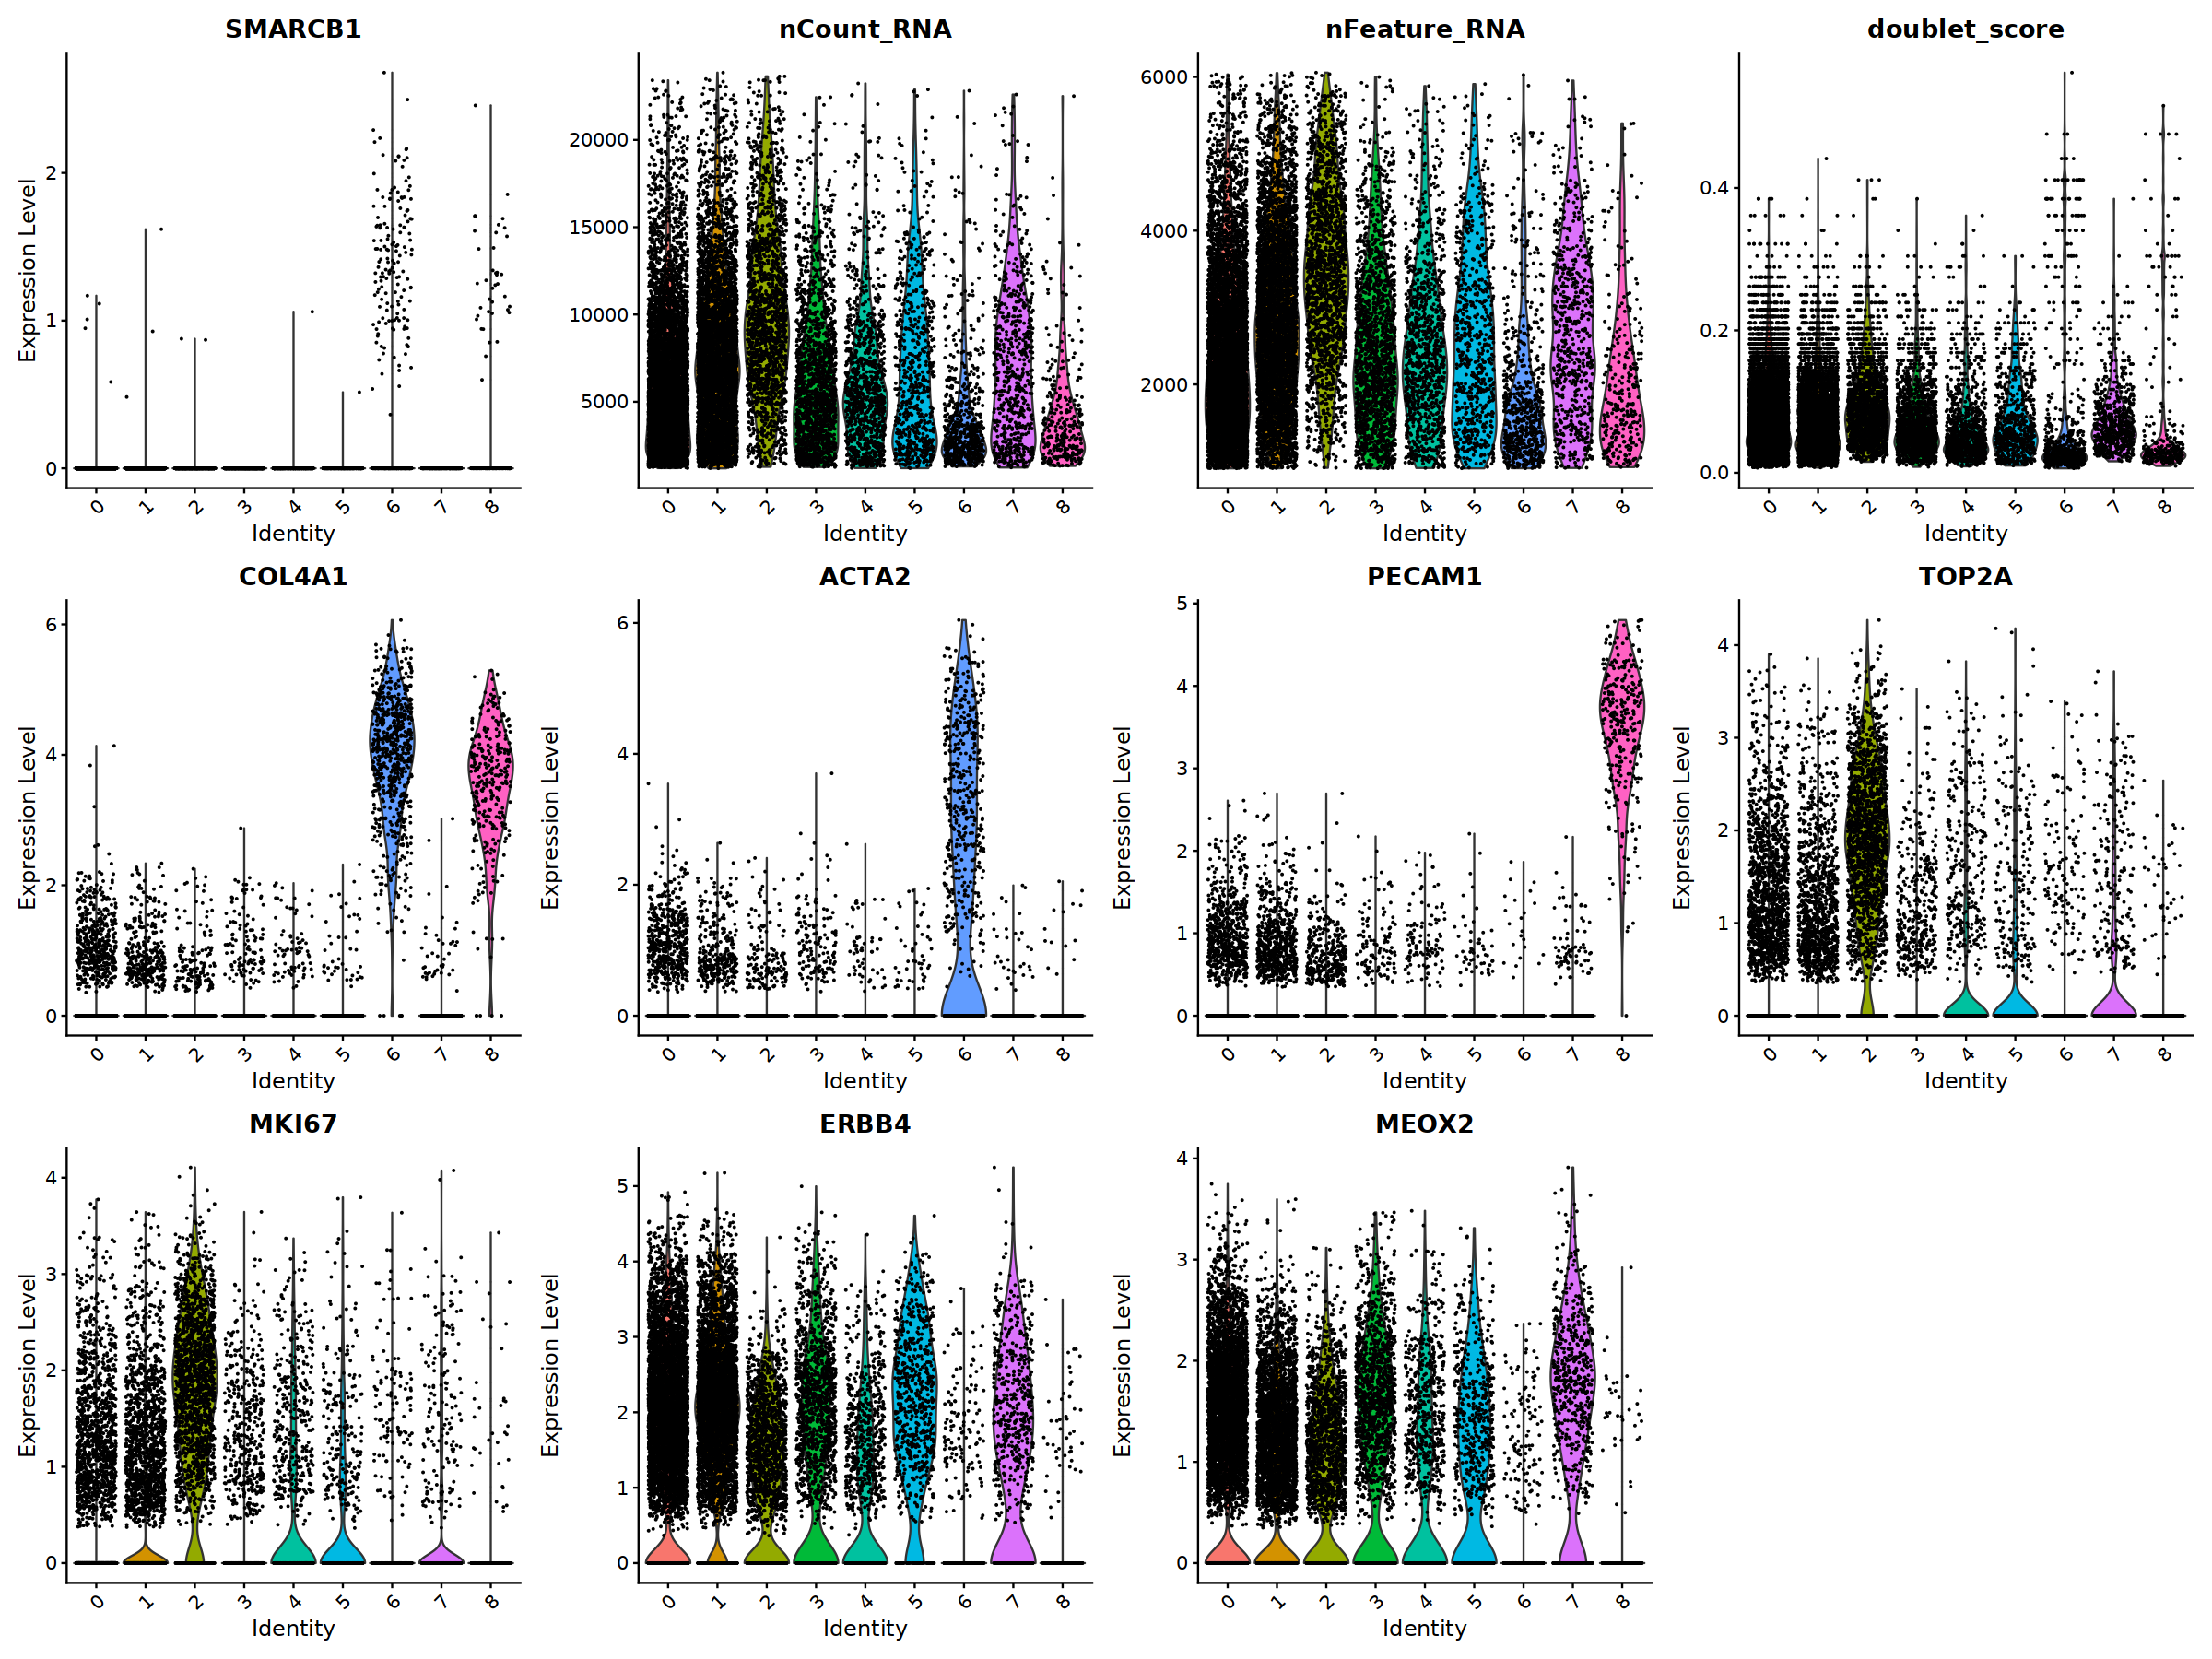

In [23]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=c("SMARCB1","nCount_RNA", "nFeature_RNA",
                              "doublet_score","COL4A1","ACTA2", "PECAM1",
                              "TOP2A", "MKI67", "ERBB4", "MEOX2"), ncol=4)

# Save

In [24]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/3.2-clustering_T0_CD45neg.rds")))

In [25]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-clustering_T0_CD45neg.csv")))

# Session Info

In [26]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=es_ES.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=es_ES.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=es_ES.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] harmony_1.0.3      Rcpp_1.0.10        gridExtra_2.3      lubridate_1.9.3   
 [5] forcats_1.0.0      stringr_1.5.0      dplyr_1.1.3        purrr_1.0.2       
 [9] readr_2.1.4        tidyr_1.3.0        tibble_3.2.1       ggplot2_3.4.4     
[13] tidyverse_2.0.0    